In [78]:
import pandas as pd 

In [79]:
data = pd.read_csv('./fastfood.csv', na_values=['-', ' ', ''])

In [80]:
data.info()
data['total_fat'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   restaurant   512 non-null    object 
 1   item         515 non-null    object 
 2   calories     515 non-null    int64  
 3   cal_fat      514 non-null    float64
 4   total_fat    515 non-null    int64  
 5   sat_fat      515 non-null    float64
 6   trans_fat    515 non-null    float64
 7   cholesterol  515 non-null    int64  
 8   sodium       515 non-null    int64  
 9   total_carb   515 non-null    int64  
 10  fiber        503 non-null    float64
 11  sugar        515 non-null    int64  
 12  protein      513 non-null    float64
 13  calcium      305 non-null    float64
dtypes: float64(6), int64(6), object(2)
memory usage: 56.5+ KB


141

In [81]:
data = data.loc[data['total_fat'] < 125]

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 513 entries, 0 to 514
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   restaurant   510 non-null    object 
 1   item         513 non-null    object 
 2   calories     513 non-null    int64  
 3   cal_fat      512 non-null    float64
 4   total_fat    513 non-null    int64  
 5   sat_fat      513 non-null    float64
 6   trans_fat    513 non-null    float64
 7   cholesterol  513 non-null    int64  
 8   sodium       513 non-null    int64  
 9   total_carb   513 non-null    int64  
 10  fiber        501 non-null    float64
 11  sugar        513 non-null    int64  
 12  protein      511 non-null    float64
 13  calcium      304 non-null    float64
dtypes: float64(6), int64(6), object(2)
memory usage: 60.1+ KB


In [83]:
print(data.isna().sum())
# Calcium has a lot of na values, we should take median or mean for it based on shapiro, we can just drop the other ones

restaurant       3
item             0
calories         0
cal_fat          1
total_fat        0
sat_fat          0
trans_fat        0
cholesterol      0
sodium           0
total_carb       0
fiber           12
sugar            0
protein          2
calcium        209
dtype: int64


In [84]:
data.drop(columns=['restaurant', 'item'], inplace=True)
data = data.loc[data['cal_fat'].notna() & data['fiber'].notna() & data['protein'].notna()]

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, 0 to 514
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   calories     499 non-null    int64  
 1   cal_fat      499 non-null    float64
 2   total_fat    499 non-null    int64  
 3   sat_fat      499 non-null    float64
 4   trans_fat    499 non-null    float64
 5   cholesterol  499 non-null    int64  
 6   sodium       499 non-null    int64  
 7   total_carb   499 non-null    int64  
 8   fiber        499 non-null    float64
 9   sugar        499 non-null    int64  
 10  protein      499 non-null    float64
 11  calcium      302 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 50.7 KB


In [86]:
# from scipy.stats import shapiro

# _, p = shapiro(data['calcium'])

# print(p)

# Droping whole column calcium because it has a lot of null values
data.drop(columns='calcium', inplace=True)

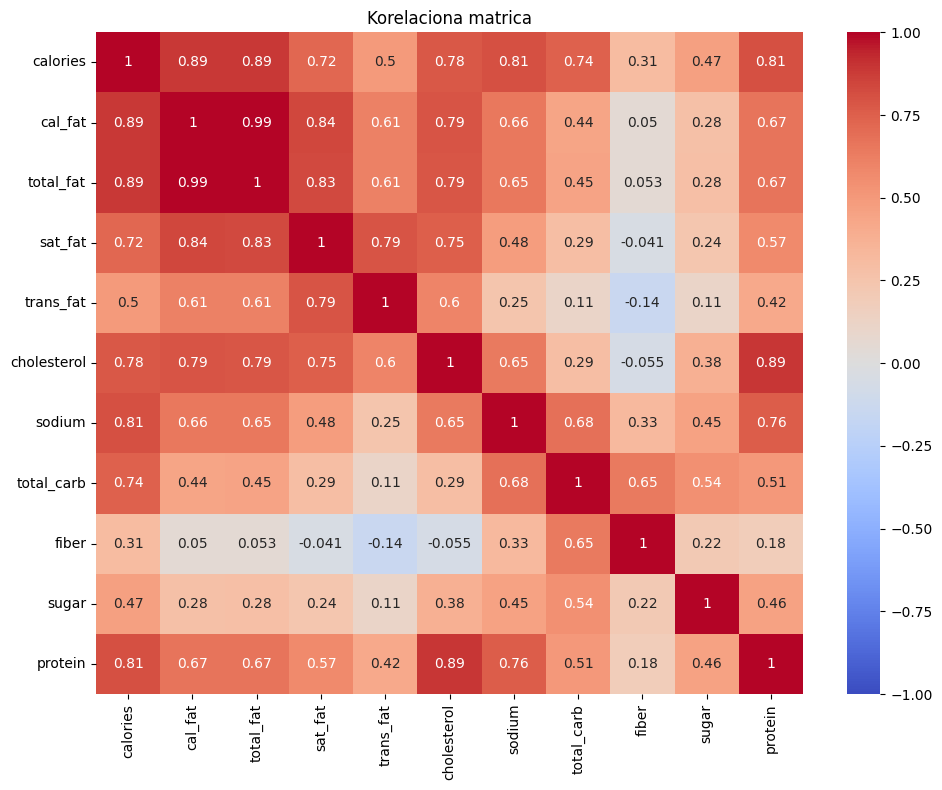

In [87]:
import seaborn as sb
import matplotlib.pyplot as plt

corr_matrix = data.corr(numeric_only=True).round(2)
plt.figure(figsize=(10, 8))
sb.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Korelaciona matrica")
plt.tight_layout()
plt.show()

In [88]:
data.drop(columns=['sat_fat', 'trans_fat', 'total_carb', 'fiber', 'sugar'], inplace=True)

In [89]:
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import statsmodels.api as sm
# from sklearn.linear_model import LinearRegression

y = data['protein']
x = data.drop(columns='protein')

train_data, test_data = train_test_split(data, test_size=0.2)
x_train = train_data.drop(columns='protein')
y_train = train_data['protein']
x_test = train_data.drop(columns='protein')
y_test = train_data['protein']

# model = LinearRegression()
model = smf.ols(f'protein ~ ' + ' + '.join(x.columns), train_data).fit()
print(model.summary())

y_pred = model.predict(x_test)

                            OLS Regression Results                            
Dep. Variable:                protein   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     1113.
Date:                Tue, 26 Aug 2025   Prob (F-statistic):          1.94e-229
Time:                        15:32:59   Log-Likelihood:                -1134.1
No. Observations:                 399   AIC:                             2280.
Df Residuals:                     393   BIC:                             2304.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.1269      0.481      2.345      

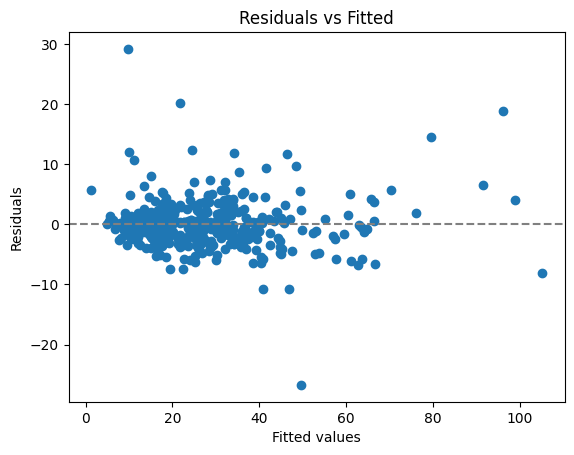

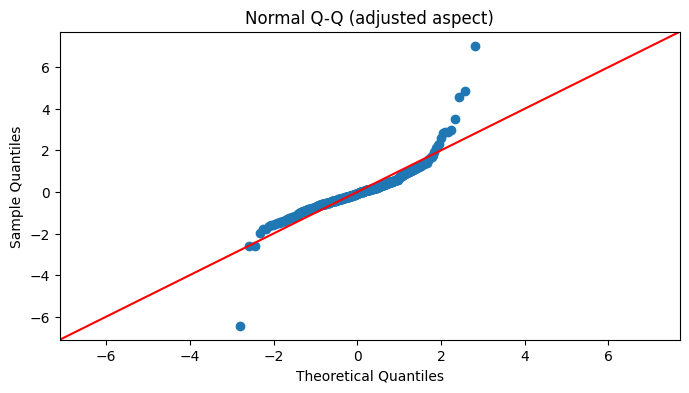

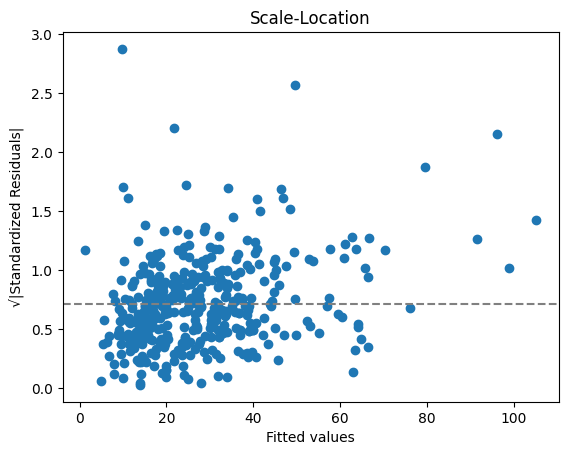

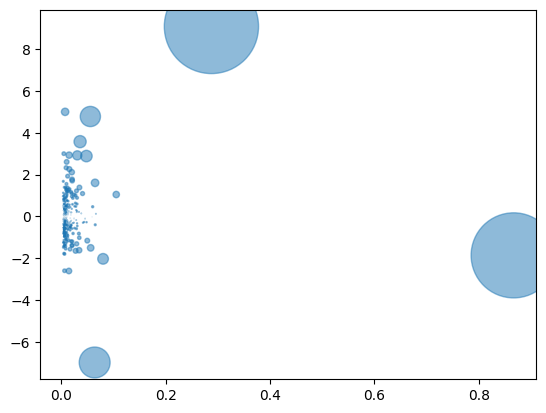

In [90]:
import numpy as np

# Residuals vs Fitted
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()
# Normal Q-Q (širi graf da linija deluje blaže)
sm.qqplot(model.resid, line='45', fit=True)
plt.gcf().set_size_inches(8, 4)
plt.title("Normal Q-Q (adjusted aspect)")
plt.show()
# Scale-Location
influence = model.get_influence()
std_resid = influence.resid_studentized_internal
abs_sqrt_resid = np.sqrt(np.abs(std_resid))
plt.scatter(model.fittedvalues, abs_sqrt_resid)
plt.axhline(np.mean(abs_sqrt_resid), color='gray', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("√|Standardized Residuals|")
plt.title("Scale-Location")
plt.show()
# Residuals vs Leverage + Cook's D threshold
leverage = influence.hat_matrix_diag
stud_resid = influence.resid_studentized_external
cooks_d = influence.cooks_distance[0]
n = len(model.model.endog)
thresh = 4 / n
plt.scatter(leverage, stud_resid, s=1000 * cooks_d, alpha=0.5)

In [91]:
# Ako su dve varijable međusobno jake kopije (visoko korelisane), one u stvari ne donose nove informacije → samo ponavljaju isto.
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import statsmodels.api as sm
import pandas as pd

# Pripremamo X: svi prediktori iz train_df + konstanta
X = sm.add_constant(x_train)
# Računamo VIF za svaki prediktor i vadimo kvadratni koren (√VIF)
# √VIF iznad 2 - potencijalna kolinearnost (prag po izboru)
print("√VIF sa svim prediktorima:")
print((pd.Series([vif(X.values, i) for i in range(X.shape[1])], index=X.columns)))
# Ponovno računanje VIF nakon izbacivanja 'tax'
X_no_cal_fat = sm.add_constant(x_train.drop(columns=['cal_fat']))
# Ponovo računamo √VIF
print((pd.Series([vif(X_no_cal_fat.values, i) for i in range(X_no_cal_fat.shape[1])], index=X_no_cal_fat.columns)))

√VIF sa svim prediktorima:
const            5.266241
calories         8.889011
cal_fat        104.659400
total_fat      103.930517
cholesterol      3.289512
sodium           3.298072
dtype: float64
const          5.251798
calories       8.823129
total_fat      5.852075
cholesterol    3.279396
sodium         3.295714
dtype: float64
